In [2]:
### 1.1. Initialize project

import pandas as pd
import numpy as np
import seaborn as sns                       
import matplotlib.pyplot as plt
#import statsmodels.api as sm
#from statsmodels.stats.outliers_influence import variance_inflation_factor

#import file
banks_ext_df = pd.read_csv('../data/bank-additional/bank-additional-full.csv', sep=';')


In [3]:
### 1.2. Prepare data for experimentation
### by dropping columns already identifies as misc,
### binning and one-hot encoding categorical variables

# Drop previously engineered fields since we have no information about them;
# also drop day_of_week since little variance from day to day, 
# duration to prevent data leakage
# and housing since it highly correlated with loan
df = banks_ext_df.drop(["day_of_week", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m","nr.employed","duration", "housing"], axis=1)

# Make varible for prior contact status
# set pdays null values to NAs
df["pdays_na"] = (df["pdays"] == 999).astype(int)
df['pdays'] = df['pdays'].replace(999, np.nan) 
# transform pdays to bins, since range 0-27, use 3 bins
df['pdays'] = pd.qcut(df['pdays'], q=3, labels=[1,2,3])

# Bin education to save dimensions
df["education"] = df["education"].map({
    "basic.4y": "primary",
    "basic.6y": "primary",
    "basic.9y": "secondary",
    "high.school": "secondary",
    "university.degree": "tertiary",
    "professional.course": "other",
    "unknown": "other",
    "illiterate": "other"
})
plt.show()
df['job'] = df['job'].replace('admin.', 'admin')

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=False)
# "job_unknown","marital_unknown","education_other","default_unknown","loan_unknown", "contact_telephone", "poutcome_nonexistent", "month_mar"
df_encoded = df_encoded.drop(columns=["y_yes", "y_no"])
df_encoded['y'] = df['y']

In [4]:
# column types
print('\nColumn Types and Non-null Values')
print('\n__Extended DF:__\n', df_encoded.info())


Column Types and Non-null Values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   41188 non-null  int64 
 1   campaign              41188 non-null  int64 
 2   previous              41188 non-null  int64 
 3   pdays_na              41188 non-null  int64 
 4   job_admin             41188 non-null  bool  
 5   job_blue-collar       41188 non-null  bool  
 6   job_entrepreneur      41188 non-null  bool  
 7   job_housemaid         41188 non-null  bool  
 8   job_management        41188 non-null  bool  
 9   job_retired           41188 non-null  bool  
 10  job_self-employed     41188 non-null  bool  
 11  job_services          41188 non-null  bool  
 12  job_student           41188 non-null  bool  
 13  job_technician        41188 non-null  bool  
 14  job_unemployed        41188 non-null  bool  
 15  jo

In [5]:
### 1.3 split data into training and testing datasets
from sklearn.model_selection import train_test_split

# create subsets for predictors (X) and dependent variable (y)
all_predictors =  df_encoded.drop(columns=["y"]).columns
X = df_encoded[all_predictors]
y = df_encoded["y"]

# split data 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# what are our distributions?
print("Original class distribution:\n", y.value_counts(normalize=True))
print("\nTraining set class distribution:\n", y_train.value_counts(normalize=True))
print("\nTesting set class distribution:\n", y_test.value_counts(normalize=True))


Original class distribution:
 y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64

Training set class distribution:
 y
no     0.887343
yes    0.112657
Name: proportion, dtype: float64

Testing set class distribution:
 y
no     0.887351
yes    0.112649
Name: proportion, dtype: float64


In [6]:
### 1.4  address imbalance in training set
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"\nTraining set class distribution before SMOTE: {Counter(y_train)}")
print(f"\nTraining set class distribution after SMOTE: {Counter(y_train_resampled)}")


Training set class distribution before SMOTE: Counter({'no': 25583, 'yes': 3248})

Training set class distribution after SMOTE: Counter({'no': 25583, 'yes': 25583})


## 2 Decision Trees Experiments
### 2.0 Building a Baseline Decision Tree model

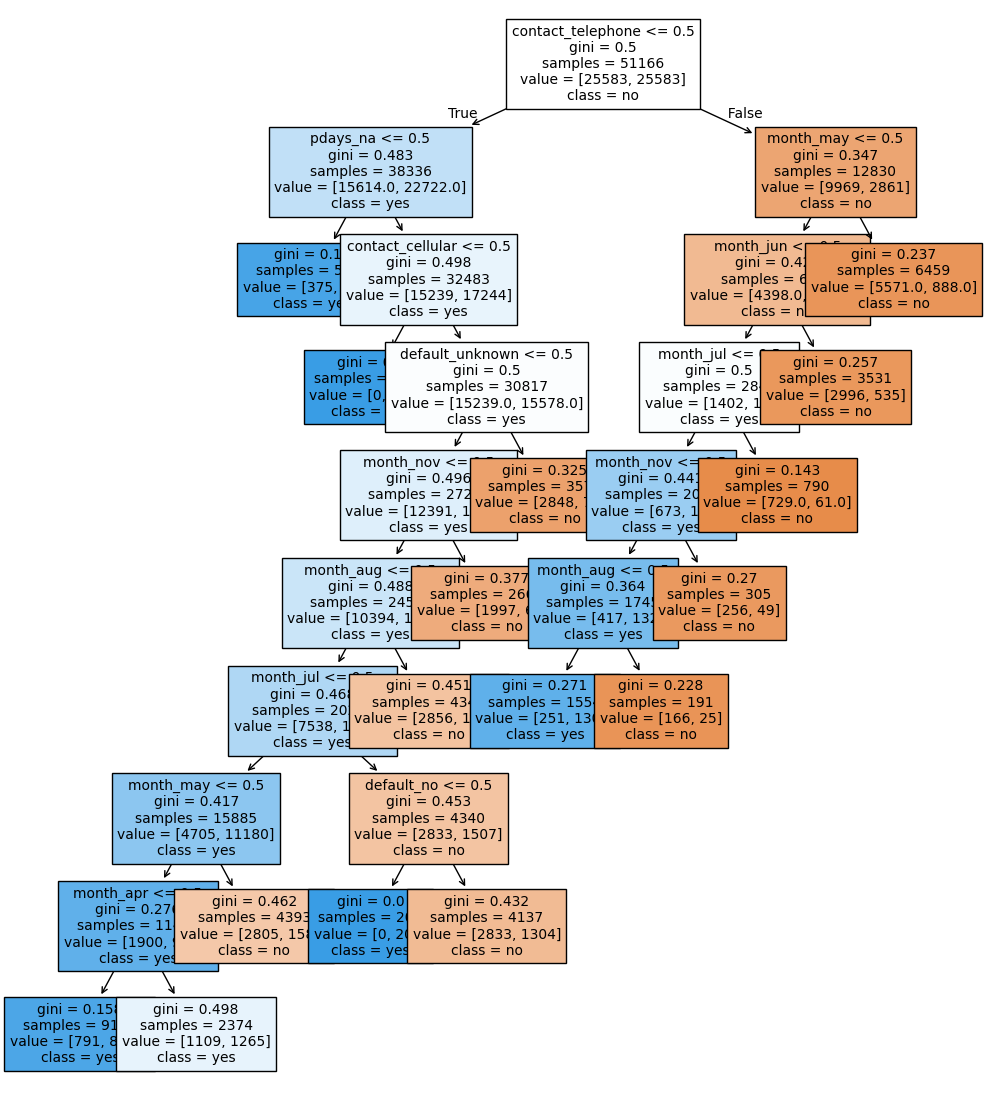

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
# import dmba

bank_tree = DecisionTreeClassifier(random_state=13, criterion='gini', min_impurity_decrease=0.003)
bank_tree.fit(X_train_resampled, y_train_resampled)
#plotDecisionTree(bank_tree, feature_names=all_predictors, class_names=bank_tree.classes_)

plt.figure(figsize=(12, 14))
plot_tree(bank_tree, 
               feature_names=all_predictors,
               class_names=bank_tree.classes_,
               filled=True, 
               fontsize=10)
plt.show()

y_pred = bank_tree.predict(X_test)

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
print(f'Confusion Matrix for Baseline Decision Tree\n', confusion_matrix(y_test, y_pred))
print(f'Testing Metrics for Baseline Decision Tree\n',classification_report(y_test, y_pred))

features = pd.DataFrame(bank_tree.feature_importances_, index=X_train_resampled.columns, columns=['importance'])
print(f'Features Sorted by Importance to Model\n', features.sort_values(by='importance', ascending=False))

Confusion Matrix for Baseline Decision Tree
 [[9881 1084]
 [ 702  690]]
Testing Metrics for Baseline Decision Tree
               precision    recall  f1-score   support

          no       0.93      0.90      0.92     10965
         yes       0.39      0.50      0.44      1392

    accuracy                           0.86     12357
   macro avg       0.66      0.70      0.68     12357
weighted avg       0.87      0.86      0.86     12357

Features sorted by Importance
                       importance
contact_telephone       0.234292
pdays_na                0.145097
month_may               0.143842
month_jul               0.113215
contact_cellular        0.068915
month_aug               0.066841
default_unknown         0.065602
month_nov               0.062080
month_apr               0.048599
month_jun               0.035335
default_no              0.016180
month_dec               0.000000
loan_no                 0.000000
loan_unknown            0.000000
loan_yes                0.00000

### 2.1 Exploring Post-Pruning settings

The below code tries to find the best cost complexity pruning alpha value 

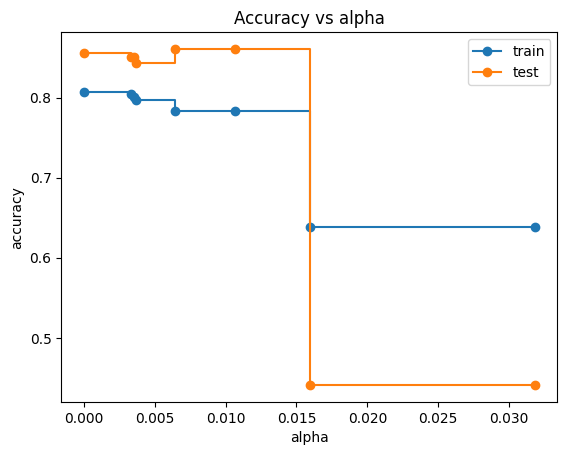

In [ ]:
# determine values for all alphas from our models ccp path
path = bank_tree.cost_complexity_pruning_path(X_train_resampled, y_train_resampled)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts = []
clf_alphas = []
# create a decision tree for each alpha value 
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=13, ccp_alpha=ccp_alpha, criterion='gini', min_impurity_decrease=0.003)
    clf_dt.fit(X_train_resampled, y_train_resampled)
    clf_dts.append(clf_dt)
    clf_alphas.append(ccp_alpha) 

train_scores = [clf_dt.score(X_train_resampled, y_train_resampled) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]


# graph tree accuracy by ccp alpha value
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()



The chart above shows that the model scores produces its highest accuracy for the test data set at or near zero before beginning to decline ~0.003. 

### 2.2.1 Use Basic Cross-Validation to Find Best CCP Alphas

<Axes: xlabel='alpha'>

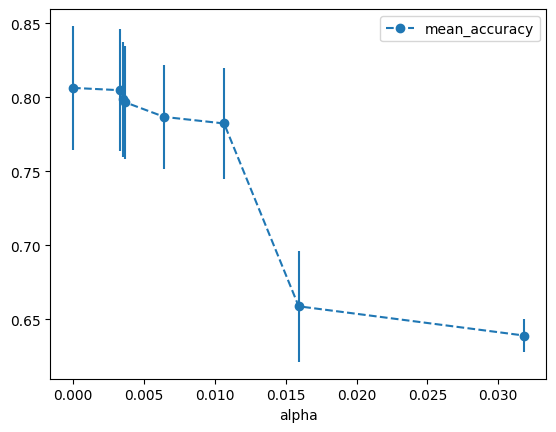

In [ ]:
# loop through our ccp_alphas and build a decision tree for each corresponding ccp_alpha,
# then store its  accuracy score in a lists
alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=13, ccp_alpha=ccp_alpha, criterion='gini', min_impurity_decrease=0.003)
    scores = cross_val_score(clf_dt, X_train_resampled, y_train_resampled, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha','mean_accuracy', 'std'])

alpha_results.plot(x='alpha', y='mean_accuracy', yerr='std', marker="o", linestyle='--')


A 10 k-fold Cross-Validation shows that the model scores best with an alpha at or near 0, with a noticable decline after .003. The mean accuracy score, however, is not 100%, suggesting that the model is not over-fitted.

In [ ]:
### 2.2.2 Use GridSearch Cross-Validation to Find Best CCP Alpha Value

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=13),
    param_grid={'ccp_alpha': ccp_alphas},
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['ccp_alpha']
print(f"Optimal ccp_alpha found by GridSearchCV: {best_alpha:.6f}")

In [ ]:
### 2.3 Find Min Impurity Decrease 

In [34]:

grid_search = GridSearchCV(
    estimator = DecisionTreeClassifier(random_state=13),
    param_grid = {'min_impurity_decrease': np.linspace(0.0, 0.05, 10)},
    cv=5,
    scoring='accuracy',
    n_jobs=-1 
)

grid_search.fit(X_train, y_train)
best_mid = grid_search.best_params_['min_impurity_decrease']
print(f"Optimal min_impurity_decrease found by GridSearchCV: {best_mid:.6f}")




Optimal min_impurity_decrease found by GridSearchCV: 0.005556


Testing Metrics for Decision Tree 2
               precision    recall  f1-score   support

          no       0.93      0.91      0.92     10965
         yes       0.40      0.46      0.43      1392

    accuracy                           0.86     12357
   macro avg       0.66      0.69      0.67     12357
weighted avg       0.87      0.86      0.87     12357



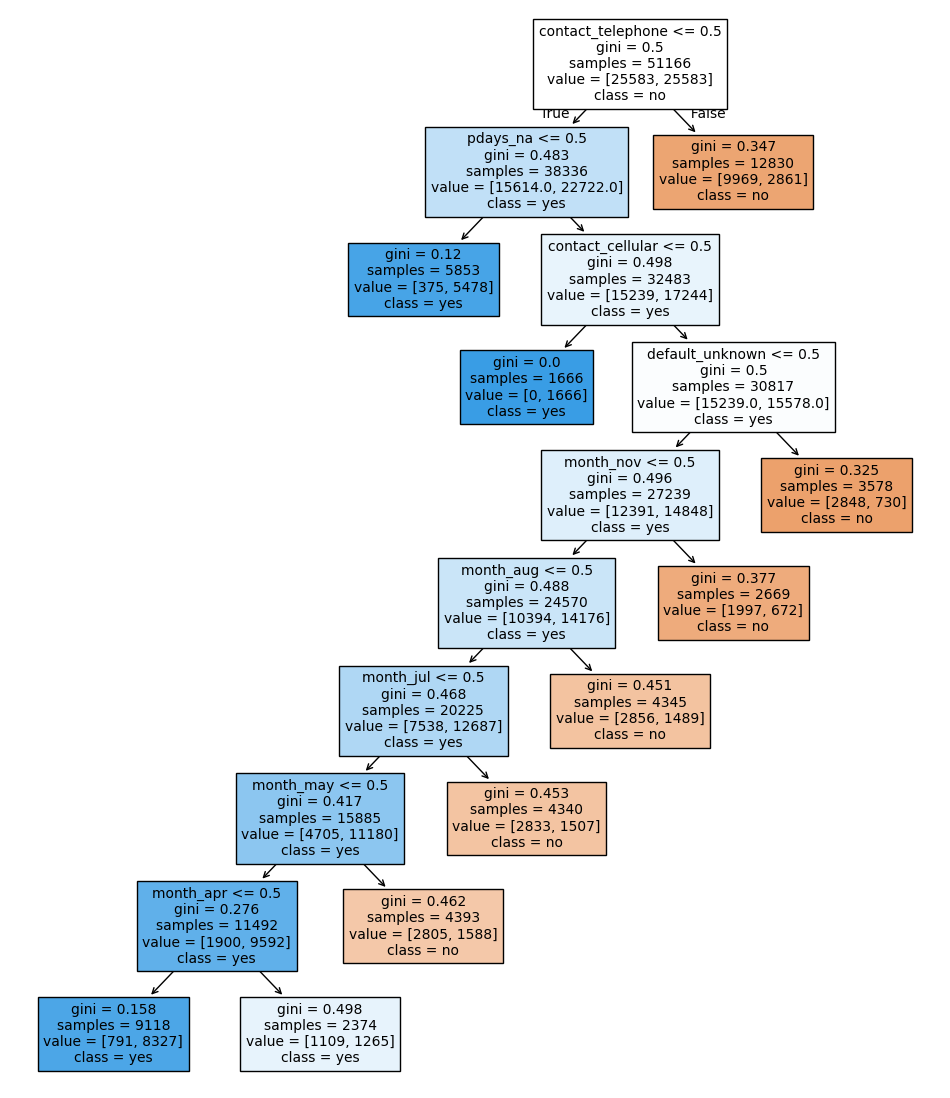

Features Sorted by Importance to Model
                       importance
contact_telephone       0.271260
pdays_na                0.167991
month_may               0.146903
month_jul               0.089473
contact_cellular        0.079789
default_unknown         0.075953
month_aug               0.059806
month_apr               0.056267
month_nov               0.052556
age                     0.000000
loan_no                 0.000000
loan_unknown            0.000000
loan_yes                0.000000
month_dec               0.000000
month_mar               0.000000
month_jun               0.000000
month_oct               0.000000
month_sep               0.000000
pdays_1                 0.000000
pdays_2                 0.000000
pdays_3                 0.000000
poutcome_failure        0.000000
poutcome_nonexistent    0.000000
default_yes             0.000000
default_no              0.000000
campaign                0.000000
job_student             0.000000
previous                0.000000
job

In [36]:
# update tree
bank_tree2 = DecisionTreeClassifier(random_state=13, criterion='gini', min_impurity_decrease=best_mid, ccp_alpha=best_alpha)
bank_tree2.fit(X_train_resampled, y_train_resampled)
y_pred = bank_tree2.predict(X_test)

print(f'Testing Metrics for Decision Tree 2\n', classification_report(y_test, y_pred))


plt.figure(figsize=(12, 14))
plot_tree(bank_tree2, 
               feature_names=all_predictors,
               class_names=bank_tree.classes_,
               filled=True, 
               fontsize=10)
plt.show()



features = pd.DataFrame(bank_tree2.feature_importances_, index=X_train_resampled.columns, columns=['importance'])
print(f'Features Sorted by Importance to Model\n', features.sort_values(by='importance', ascending=False))

## Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)

rf = RandomForestClassifier(n_estimators=500, random_state=1, oob_score=True)
rf.fit(X, y)


NameError: name 'X' is not defined

/home/pi/Documents/Data622/myvenv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


<Axes: xlabel='n'>

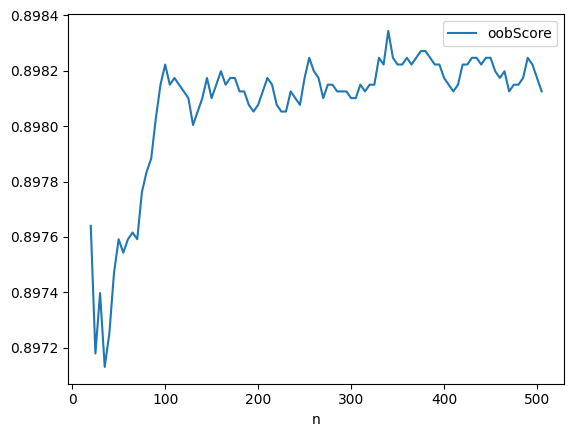

In [ ]:

n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, criterion='entropy', max_depth=5, random_state=1, oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)

df = pd.DataFrame({ 'n' : n_estimator, 'oobScore' : oobScores })
df.plot(x='n', y='oobScore')

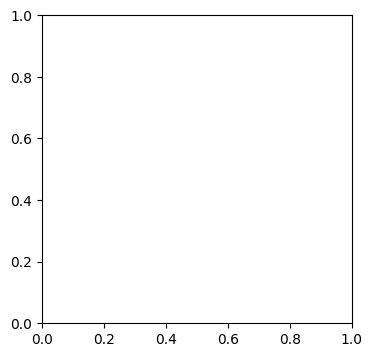

In [ ]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(4, 4))

#prediction.loc[predictions.prediction='1']

In [ ]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(base_estimator=bank_tree, n_estimator=500, learning_rate=0.1, random_state=1)
tree = bank_tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
#tree_train = accuracy_score(y_train, y_train_pred)
#tree_test = accuracy_score(y_train, y_test_pred)
#print(f'Decision tree train/test accuracies ' f'{tree_train:.3f}/tree_test:.3f') 


TypeError: AdaBoostClassifier.__init__() got an unexpected keyword argument 'base_estimator'